Demonstration of CVAE as in Doersch's tutorial.

In [60]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from cvaegan_conv import Encoder,Decoder
from cvae2 import Conditional_Variational_Autoencoder
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
#from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from dataset import DataSet
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Label

In [62]:
tf.reset_default_graph()

In [37]:
# Training
sess = tf.InteractiveSession()
build_encoder = Encoder()
build_decoder = Decoder()
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,x_dim = 784,dataset = mnist.train,
                                            learning_rate = 5e-4, num_epochs = 10, lr_decay=0.9,
                                            checkpoint_name = 'cvae_conv')


In [52]:
model.train()


Epoch 16 loss: 96.7649899986 (time: 128.092345953 s)
Epoch 17 loss: 96.4610920854 (time: 124.894894838 s)
Epoch 18 loss: 96.0452887656 (time: 119.244368076 s)
Epoch 19 loss: 95.6094113853 (time: 120.720744133 s)
Epoch 20 loss: 95.3472758068 (time: 122.311146021 s)
Epoch 21 loss: 95.1546951433 (time: 113.267647982 s)
Epoch 22 loss: 94.6931640764 (time: 74.6592400074 s)
Epoch 23 loss: 94.4955642978 (time: 73.6392869949 s)
Epoch 24 loss: 94.2462480302 (time: 74.8617839813 s)
Epoch 25 loss: 94.1975168956 (time: 72.9824149609 s)
0.0908555984497 min


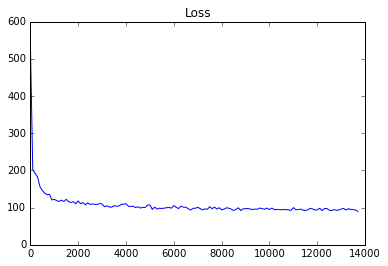

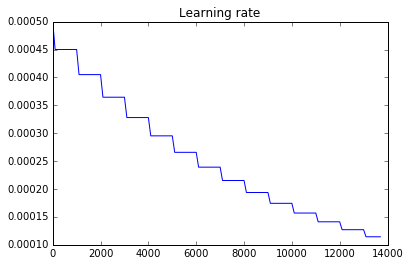

In [53]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()
plt.plot(log[0,], log[2,])
plt.title('Learning rate')
plt.show()

In [64]:
# Load checkpoint
sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,x_dim = 784,dataset = mnist.train,
                                            learning_rate = 0.001, num_epochs = 50,
                                            load = True, load_file = 'checkpoints/cvae_conv_good2',
                                           checkpoint_name='test')

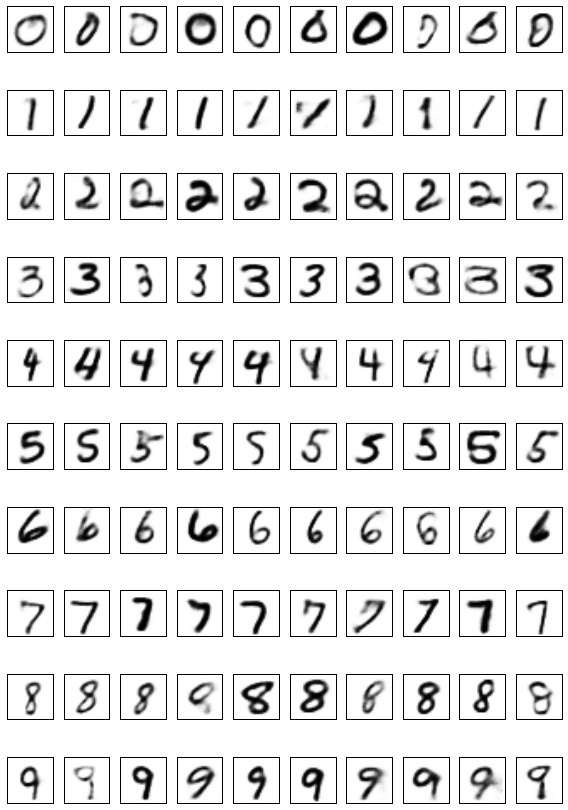

In [65]:
#images, info = mnist.test.next_batch(100)
num_examples = 10

info = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=100, info=info)

num_show = 5
plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/cvae_conv_gen')
plt.show()

# Style

In [66]:
testx = mnist.test.images[xrange(100)]
testy = mnist.test.labels[xrange(100)]
mu, log_sigma2 = sess.run([model.encoder_mean, model.encoder_log_sigma2],
                         feed_dict = {model.x: testx, model.y: testy})

generated_images = np.zeros((10, 100, 28*28))
for j in xrange(10):
    info = np.repeat(np.identity(10)[j,].reshape(1,-1), 100, axis=0) # hack for repeating label j
    generated_images[j,:,:] = sess.run(model.decoder_mean,
                                      feed_dict = {model.eps : np.random.randn(100, 50),
                                                  model.y: info,
                                                  model.encoder_mean: mu,
                                                  model.encoder_log_sigma2: log_sigma2})

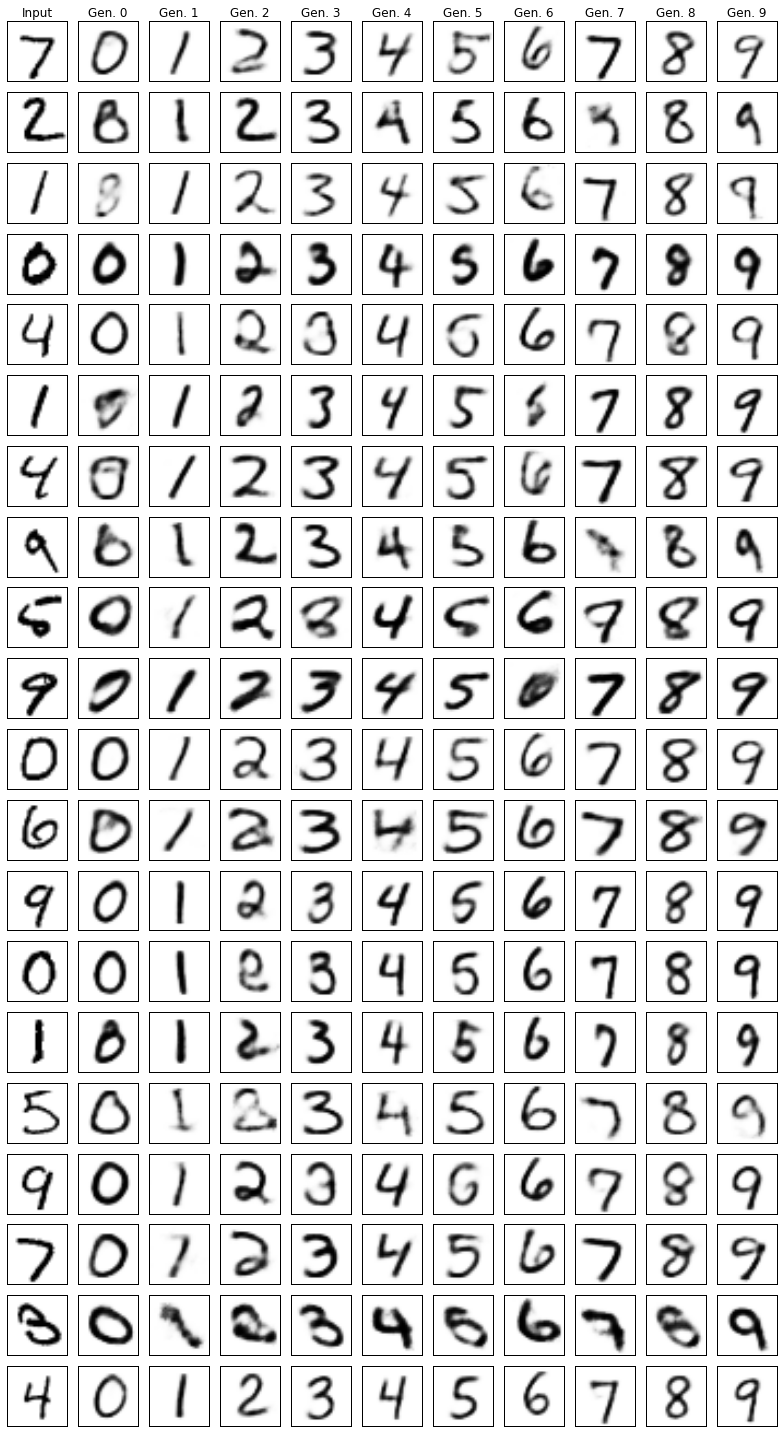

In [67]:
subset = xrange(20)
testx_subset = testx[subset]
generated_images_subset = generated_images[:, subset, :]

plt.figure(figsize=(11,len(subset)))
#plt.figure(figsize=(len(subset),11))
for i in xrange(len(subset)):
    plt.subplot(len(subset), 11, 11*i+1)
    plt.imshow(testx_subset[i].reshape(28,28), cmap='gray_r')
    if i == 0:
        plt.title('Input')
    plt.xticks([])
    plt.yticks([])
    for j in xrange(10):
        plt.subplot(len(subset),11, 11*i+j+2)
        plt.imshow(generated_images_subset[j,i,:].reshape(28,28), cmap='gray_r')
        if i == 0:
            plt.title('Gen. {}'.format(j))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/style_cvae_conv_gen')
plt.show()

In [15]:
sess.close()
tf.reset_default_graph()